# Importing the relevant libraries

**The Business Case**

Machine learning’s numerous implications include improving business decision-making. This project provides a practical illustration of this use case. It focuses on predicting the likelihood of a student registered for a free plan purchasing a subscription on our platform. The decision is based on students’ activities on the platform—viewing lectures and participating in exams.

The project is inspired by an initiative 365 had in 2022 to predict student purchases before our Black Friday campaign. We wanted to create a list of students likelier to purchase and retarget them with unique ads on social media. But as it turned out, this was no easy task due to the extreme imbalance of the data—the number of students who had never purchased a subscription was much higher than the number of students who had. The primary reason for that was the free campaign we ran before the Black Friday one, where the platform was unlocked for free to all 365 students.

As you will see, such class imbalance combined with humans’ unpredictable behavior makes it challenging to predict student purchases.


**The Database**

The database you’ll work with consists of seven columns used as predictor variables and one as a target variable (the purchased column). The target variable is a binary column where 0 indicates a student who hasn’t bought a subscription and 1 represents a student who has. All predictor variables (except student_country) store metrics related to student behavior recorded between the following:

Registration date and the last available date in our dataset: Oct 20, 2022, when the purchased column equals 0
Registration date and their first purchase when the purchased column equals 1
In this way, we study students’ behavior only during their free-plan period on the platform.


**Importing the Database**

The first step to creating a machine learning model is importing the data source. Import the data in the ml_datasource.csv file and carefully study the output.

In [1]:
# Import necessary packages

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.model_selection
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier

# Data Preprocessing

### Importing the Database

In [2]:
# Import the data from the CSV file
file_path = 'ml_datasource.csv'
raw_data = pd.read_csv(file_path)

# View first five rows
raw_data.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


In [3]:
#Copy dataframe

data = raw_data.copy()
data.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


### Removing Outliers

Examine the distribution plots of the numerical features and study their skewness.

In [4]:
# Set default theme
sns.set_theme()

<Axes: xlabel='purchased', ylabel='Density'>

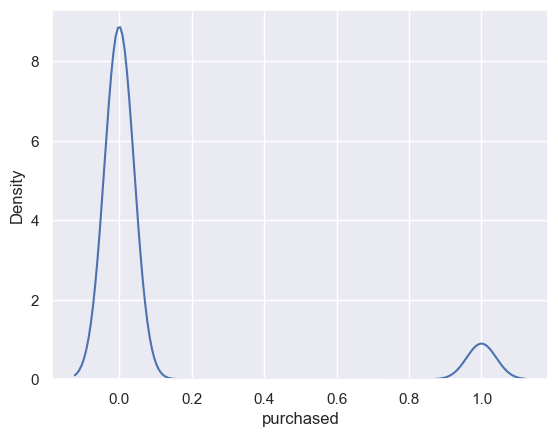

In [5]:
# Plot purchased column

sns.kdeplot(data=data, x='purchased')

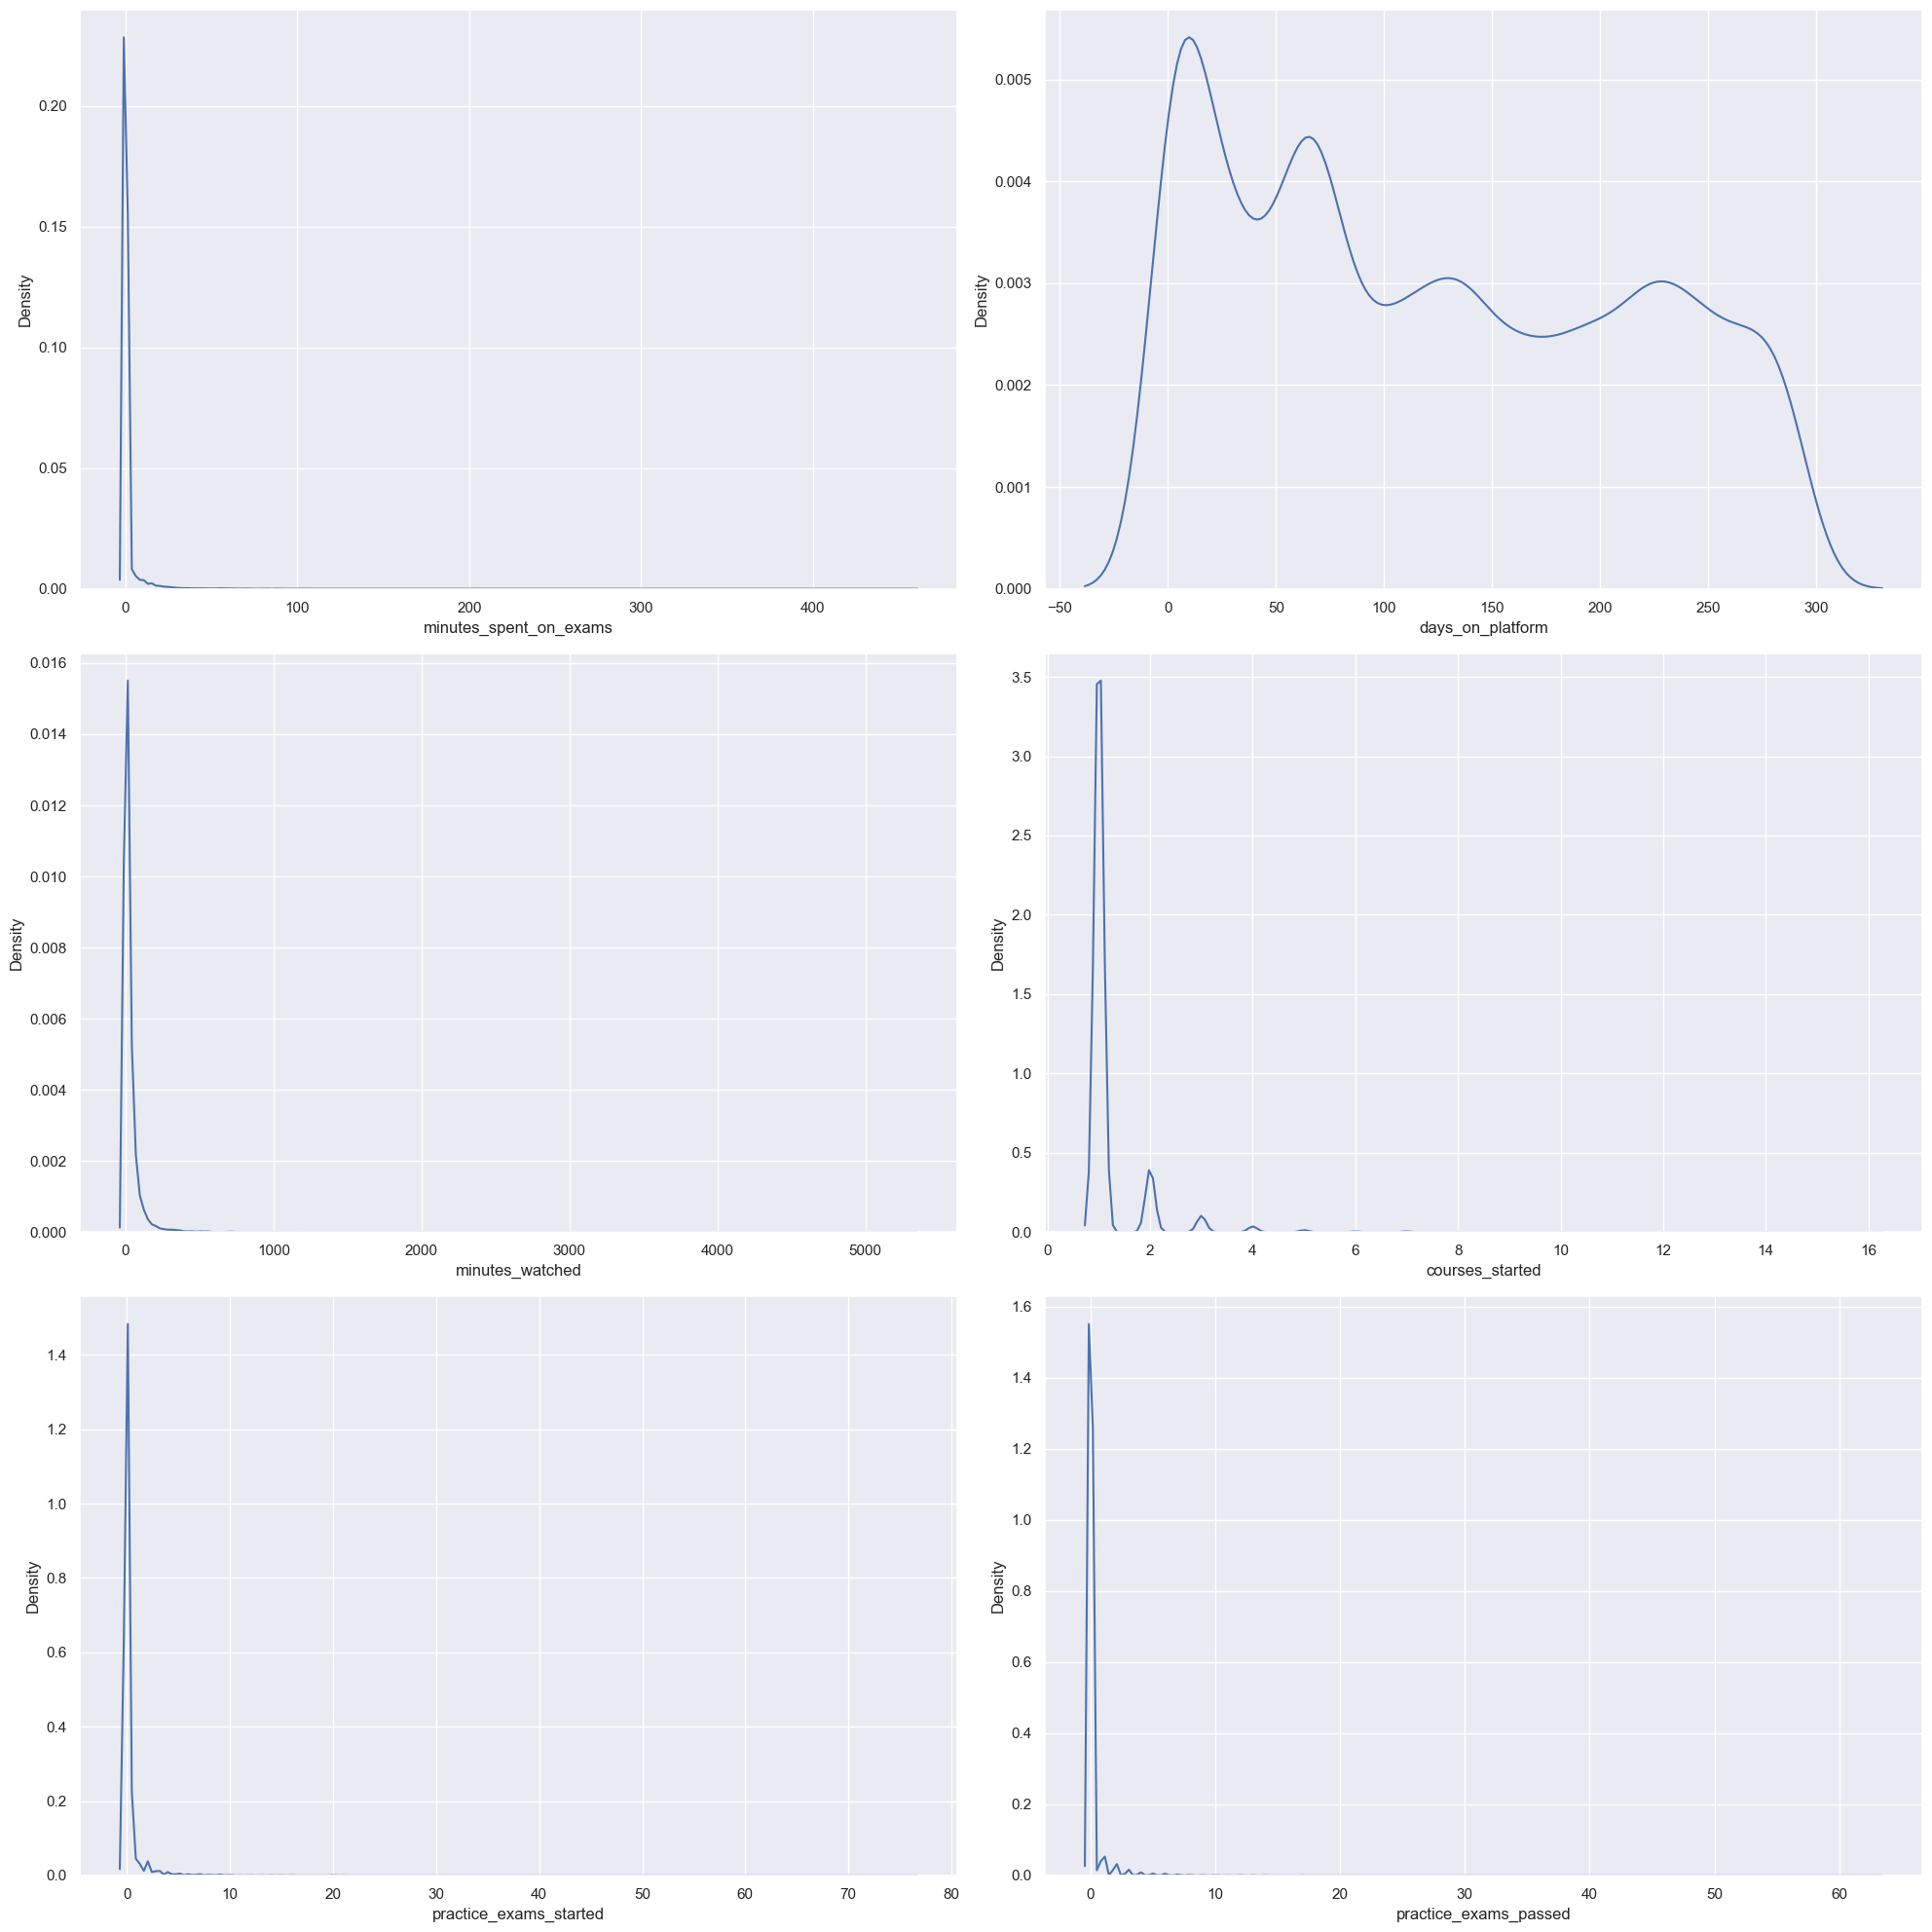

In [6]:
# Create subplots to view all numerical columns 

fig, axes = plt.subplots(3, 2, figsize=(20,20))

sns.kdeplot(data['minutes_spent_on_exams'], ax=axes[0,0])
sns.kdeplot(data['days_on_platform'], ax=axes[0,1])
sns.kdeplot(data['minutes_watched'], ax=axes[1,0])
sns.kdeplot(data['courses_started'], ax=axes[1,1])
sns.kdeplot(data['practice_exams_started'], ax=axes[2,0])
sns.kdeplot(data['practice_exams_passed'], ax=axes[2,1])

plt.tight_layout()

plt.show()

In [7]:
# filter dataframe to exclude outliers
data_no_outliers = data.loc[(data['minutes_watched'] <= 1000) &
                        (data['courses_started'] <= 10) &
                        (data['practice_exams_started'] <= 10) &
                        (data['minutes_spent_on_exams'] <= 40)]

In [8]:
# verify outliers were removed
data.shape

(17761, 8)

In [9]:
# verify outliers were removed
data_no_outliers.shape

(17626, 8)

In [10]:
data_no_outliers.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


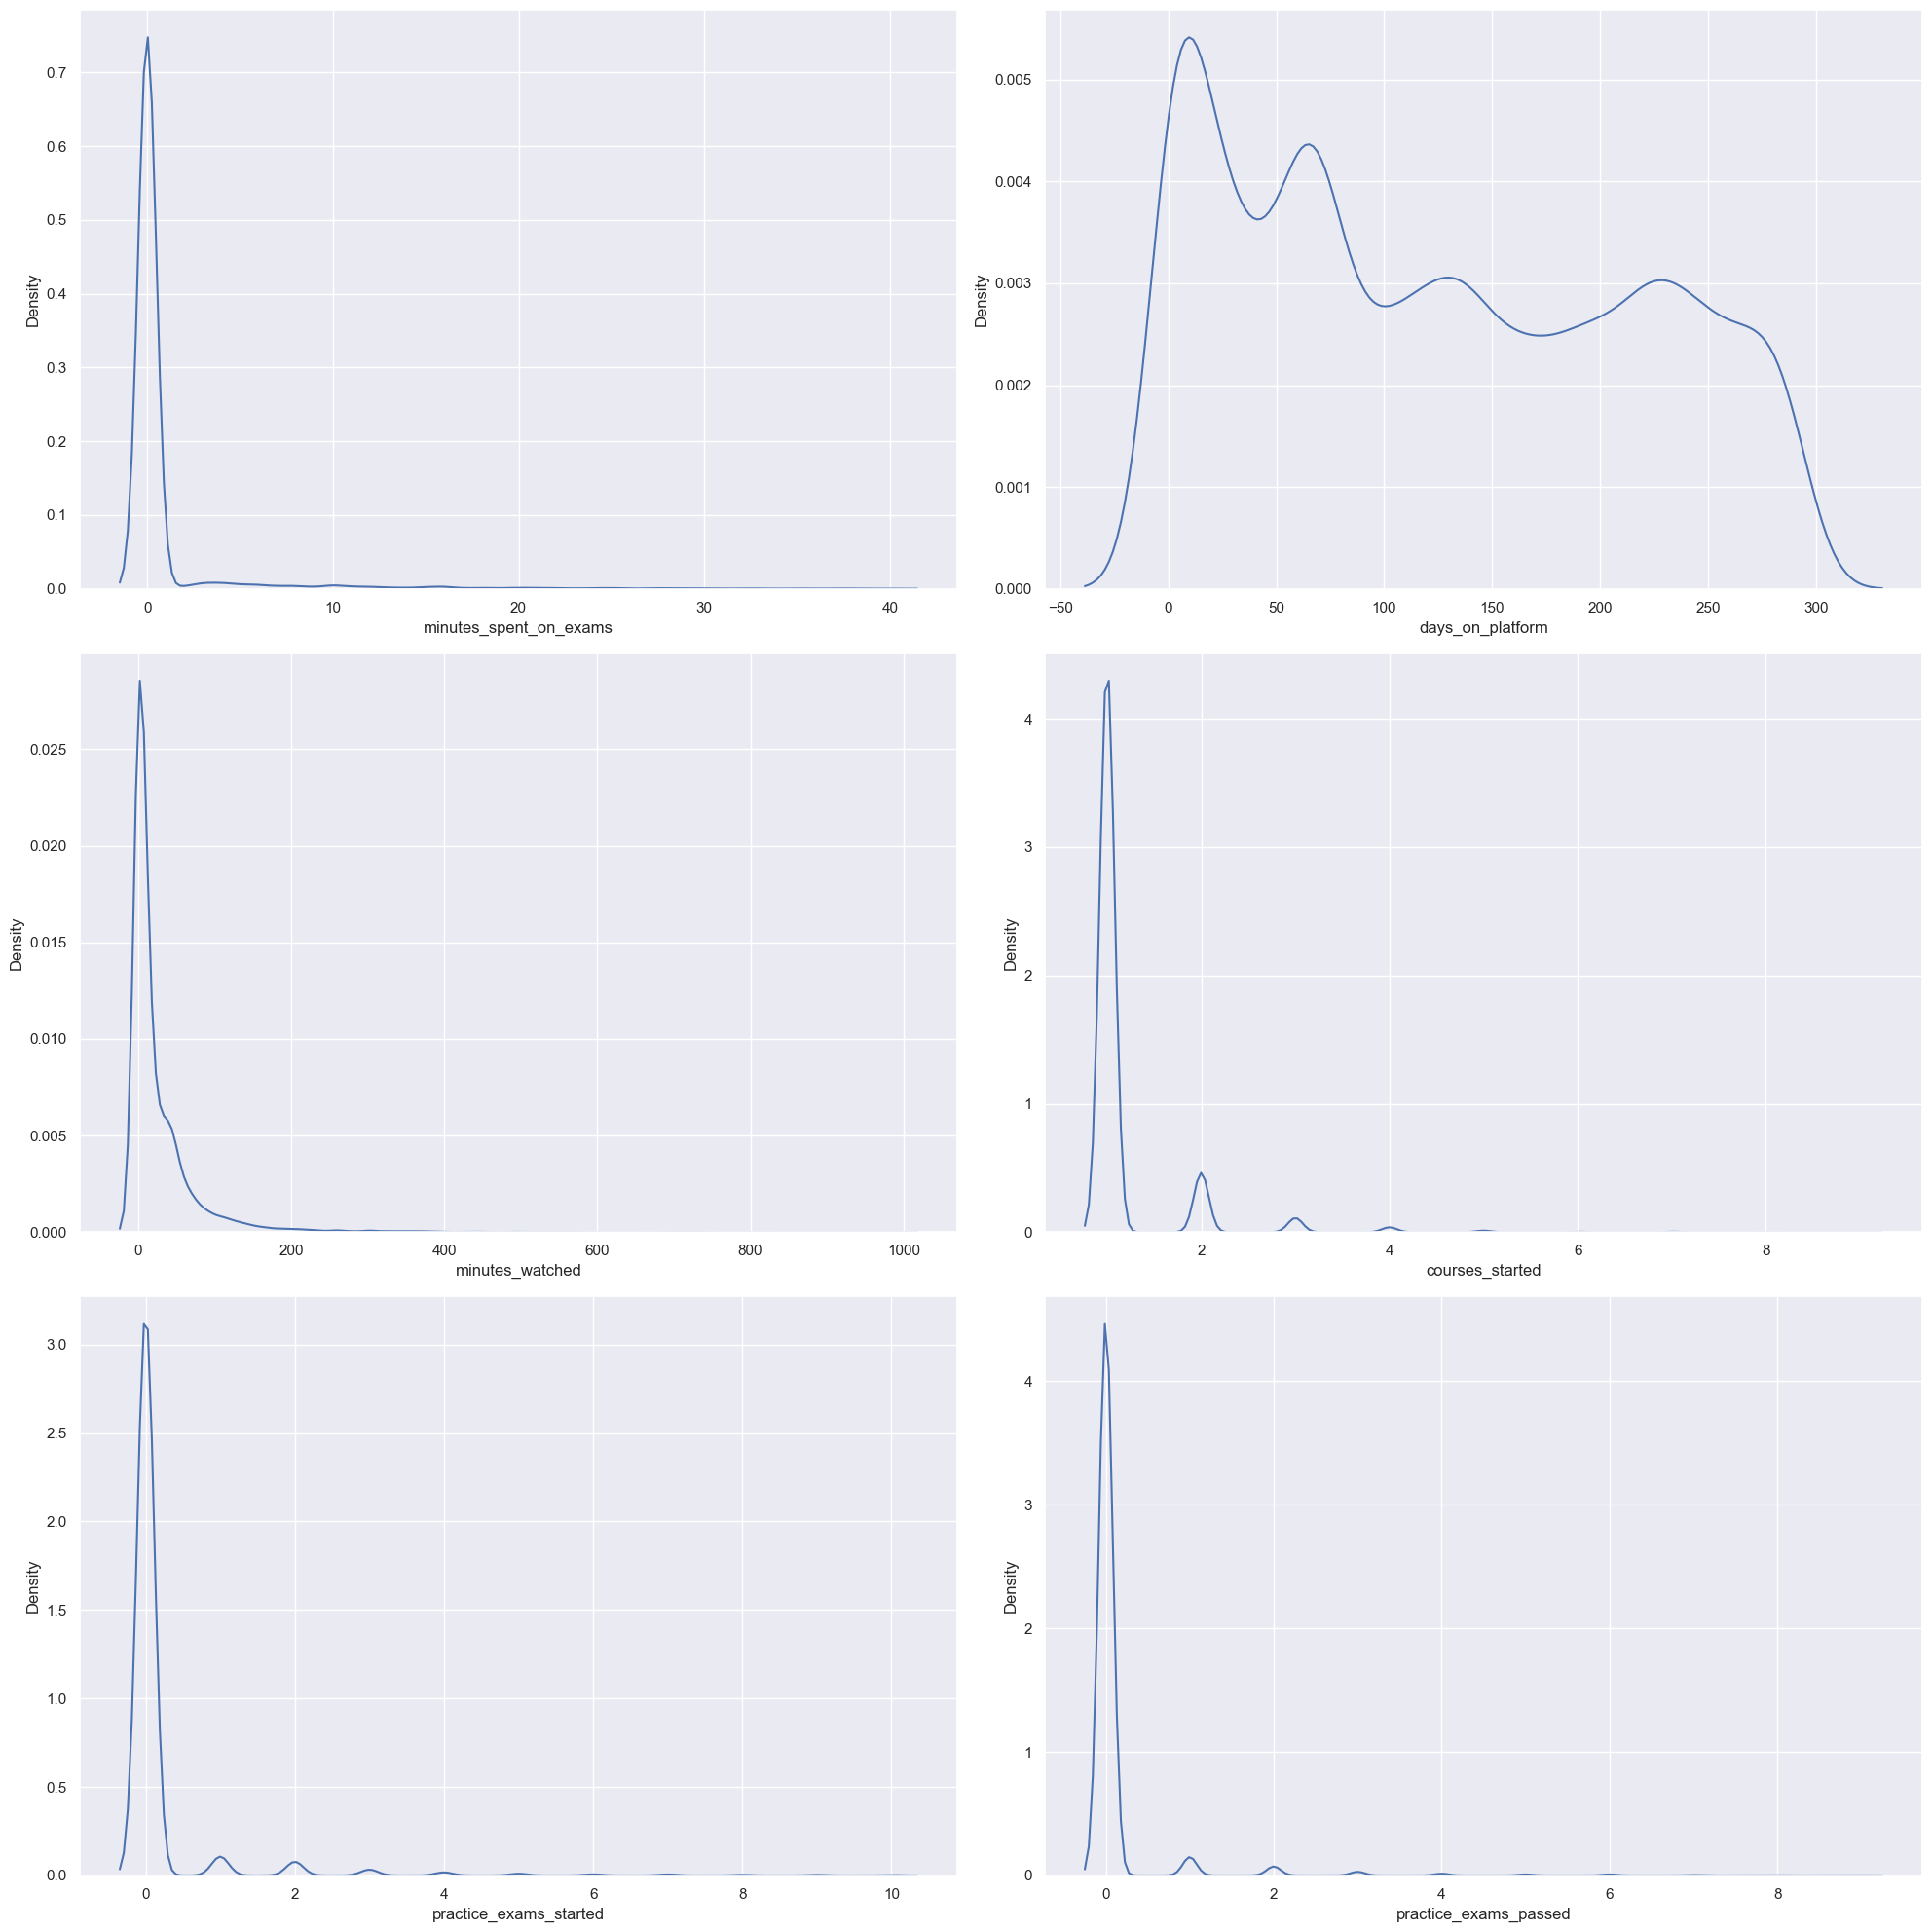

In [11]:
# create subplots with new dataframe

fig, axes = plt.subplots(3, 2, figsize=(20,20))

sns.kdeplot(data_no_outliers['minutes_spent_on_exams'], ax=axes[0,0])
sns.kdeplot(data_no_outliers['days_on_platform'], ax=axes[0,1])
sns.kdeplot(data_no_outliers['minutes_watched'], ax=axes[1,0])
sns.kdeplot(data_no_outliers['courses_started'], ax=axes[1,1])
sns.kdeplot(data_no_outliers['practice_exams_started'], ax=axes[2,0])
sns.kdeplot(data_no_outliers['practice_exams_passed'], ax=axes[2,1])

plt.tight_layout()

plt.show()

### Checking for Multicollinearity

Your task now is to check for multicollinearity in the data using the variance inflation factor (VIF) metric. Identify and remove the numerical feature with the highest VIF value. This is done because this feature is likely redundant with others in the dataset, and its removal can help reduce multicollinearity. After removing the column, calculate the VIF values again for the remaining numerical features. Now identify the feature with the highest VIF value. Is this value larger than 5?

In [12]:
# View column names
data_no_outliers.columns.to_numpy()

array(['student_country', 'days_on_platform', 'minutes_watched',
       'courses_started', 'practice_exams_started',
       'practice_exams_passed', 'minutes_spent_on_exams', 'purchased'],
      dtype=object)

In [13]:
# Inspect VIF value on dataframe
# Add a constant term to the independent variables
X = sm.add_constant(data_no_outliers[['minutes_spent_on_exams', 'days_on_platform',
                                      'minutes_watched','courses_started',
                                     'practice_exams_started', 'practice_exams_passed',
                                      'purchased']])

# Calculate VIF for each variable
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

   VIF Factor                features
0    8.369010                   const
1    3.196568  minutes_spent_on_exams
2    1.211302        days_on_platform
3    1.585815         minutes_watched
4    1.364688         courses_started
5    9.744814  practice_exams_started
6    7.523045   practice_exams_passed
7    1.240166               purchased


In [14]:
# Drop column with highest VIF value
data_no_mult = data_no_outliers.drop('practice_exams_started', axis=1)
data_no_mult.head()

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,15.81,0
1,SG,260,1.7,1,0,16.00,0
2,TR,260,22.4,1,0,0.93,0
3,KE,259,18.8,1,1,14.63,0
4,IN,259,118.0,2,1,16.48,0


In [15]:
# Inspect VIF value again on new dataframe

# Add a constant term to the independent variables
X = sm.add_constant(data_no_mult[['minutes_spent_on_exams', 'days_on_platform',
                                      'minutes_watched','courses_started',
                                     'practice_exams_passed',
                                     'purchased']])

# Calculate VIF for each variable
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

   VIF Factor                features
0    8.345685                   const
1    2.491684  minutes_spent_on_exams
2    1.208018        days_on_platform
3    1.584141         minutes_watched
4    1.364560         courses_started
5    2.476508   practice_exams_passed
6    1.238521               purchased


### Dealing with NaN Values

In [16]:
# Check for null values
data_no_mult.isnull().sum()

student_country           8
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

In [17]:
# View rows with Nan values
data_no_mult.loc[data_no_mult['student_country'].isna()]

,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
311,NaN,88,58.1,1,2,11.20,1
337,NaN,86,43.0,1,2,12.96,0
556,NaN,121,241.9,2,3,21.29,0
806,NaN,64,86.4,1,2,4.98,0
1097,NaN,72,67.5,1,1,6.27,0
12363,NaN,84,6.2,1,0,0.00,0
12633,NaN,78,3.0,1,0,0.00,0
16946,NaN,11,8.2,1,0,0.00,0


In [18]:
# substitute null values with correct student country
data_no_nulls = data_no_mult.fillna({'student_country':'NAM'})

In [19]:
# Verify substitution
data_no_nulls.loc[ data_no_nulls['student_country'] == 'NAM', 'student_country']

311      NAM
337      NAM
556      NAM
806      NAM
1097     NAM
12363    NAM
12633    NAM
16946    NAM
Name: student_country, dtype: object

In [20]:
# Verifiy no null values
data_no_nulls.isnull().sum()

student_country           0
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

### Splitting the Data

Now that the data’s been preprocessed, it’s time to split it into targets and inputs. The former should include only the purchased column, while the latter should contain all columns except the purchased one.

Once that’s done, split the data further into training and testing sets with the following conditions:

- A 20% test size
- A random state of 365
- A stratified split for the target variable

In [21]:
# Create input variables
X = data_no_nulls.drop('purchased', axis=1)

# Create target variable
y = data_no_nulls['purchased']

# Split the data
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20, random_state=365, stratify=y)


### Encoding the Data

Before feeding the data to any training algorithm, we must store all features as numerical values. We should therefore deal with the student_country column storing values of a string data type. In this project, we’ll achieve this using the OrdinalEncoder class provided by sklearn.

In [22]:
# Initialize instace of the OrdinalEncoder class
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=170)

# Fit and transform the student_country column in training data
x_train['student_country_enc'] = enc.fit_transform(x_train['student_country'].to_numpy().reshape(-1, 1))
x_test['student_country_enc'] = enc.fit_transform(x_test['student_country'].to_numpy().reshape(-1, 1));

In [23]:
# Drop the original student_country column from the training and testing datasets
x_train.drop('student_country', axis=1, inplace = True)
x_test.drop('student_country', axis=1, inplace = True)

In [24]:
# To avoid library incompatibility issues, convert training and testing datasets into numpy ndarrays

x_train_array = np.asarray(x_train, dtype = 'float')
y_train_array = np.asarray(y_train, dtype = 'int')
x_test_array = np.asarray(x_test, dtype = 'float')
y_test_array = np.asarray(y_test, dtype = 'int')

# Creating a Logistic Regression Model

In [25]:
# Setup logistic regression model
log_reg = sm.Logit(y_train_array, x_train_array)

In [26]:
# Fit the log_reg model
log_reg_results = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.153146
         Iterations 10


In [27]:
# View model statistical information 
log_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                14100
Model:                          Logit   Df Residuals:                    14094
Method:                           MLE   Df Model:                            5
Date:                Tue, 19 Nov 2024   Pseudo R-squ.:                  0.5019
Time:                        12:56:48   Log-Likelihood:                -2159.4
converged:                       True   LL-Null:                       -4334.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0691      0.002    -31.914      0.000      -0.073      -0.065
x2             0.0144      0.001     19.992      0.000       0.013       0.016
x3            -0.2885      0.060     -4.784      0.000      -0.407      -0.170
x4             0.0840      0.076      1.102      0.270      -0.065       0.233
x5            -0.0670      0.015     -4.332      0.000      -0.097      -0.037
x6             0.0026      0.001      3.983      0.000       0.001       0.004
==============================================================================

Possibly complete quasi-separation: A fraction 0.43 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [28]:
# Make predictions 
y_hat = log_reg_results.predict(x_test_array)

In [29]:
print(y_hat)

[2.58099219e-09 1.62098293e-02 2.90603770e-02 ... 5.99373252e-03
 4.67976607e-01 9.01521389e-08]


In [30]:
rounded_predictions = np.round(y_hat).astype(int)
rounded_predictions

array([0, 0, 0, ..., 0, 0, 0])

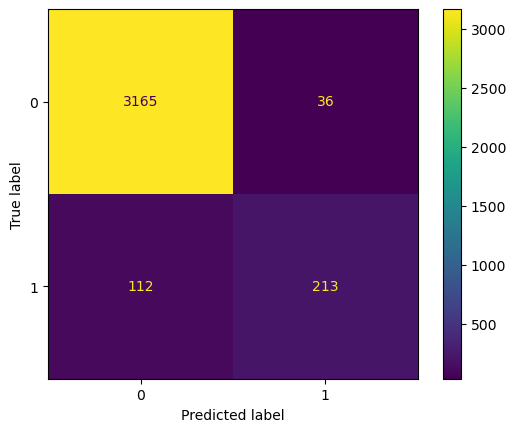

In [31]:
# Create confusion matrix
sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(y_test_array, rounded_predictions)
plt.show()

# Creating a K-Nearest Neighbors Model

In [32]:
# Create KNN instance
knn = KNeighborsClassifier()

# Define the parameter grid for grid search
parameters_knn = {
    'n_neighbors': range(1,51),  # Test different values of k
    'weights': ['uniform', 'distance'],  # Test different weight functions
}

# Create a GridSearchCV instance
grid_search_knn = GridSearchCV(estimator=knn, param_grid=parameters_knn, scoring='accuracy')
grid_search_knn.fit(x_train_array, y_train_array)

# Get the best parameters and best estimator
best_params = grid_search_knn.best_params_
best_knn = grid_search_knn.best_estimator_

# Make predictions
y_test_pred_knn = best_knn.predict(x_test_array)

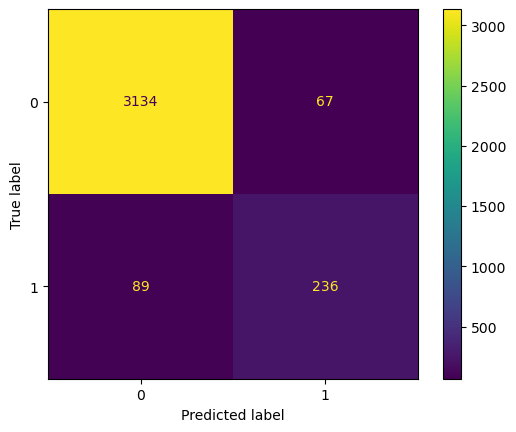

In [33]:
# Build confusion matrix
sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(y_test_array, y_test_pred_knn)
plt.show()

In [34]:
# Generate classification report
print(classification_report(y_test_array, y_test_pred_knn))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.78      0.73      0.75       325

    accuracy                           0.96      3526
   macro avg       0.88      0.85      0.86      3526
weighted avg       0.95      0.96      0.96      3526



# Creating a Support Vector Machines Model

In [35]:
# Create instance of MinMaxScaler to normalize features 
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit_transform(x_train_array)
scaler.transform(x_test_array)

array([[ 0.94520548, -0.99879288, -1.        , -1.        , -1.        ,
        -0.32098765],
       [-0.54794521, -0.86802133, -0.75      , -1.        , -1.        ,
        -0.58024691],
       [-0.67123288, -0.86862489, -0.25      , -1.        , -1.        ,
        -0.90123457],
       ...,
       [-0.51369863, -0.90443617, -0.5       , -0.11111111, -0.49      ,
         0.56790123],
       [-1.        , -0.99778694, -1.        , -1.        , -1.        ,
        -0.30864198],
       [ 0.65753425, -0.93602253, -1.        , -1.        , -1.        ,
         0.64197531]])

In [36]:
# Create SVC instance 
svm = SVC()

# Set up paramters
parameters_svm = {'C': [1, 10], 'kernel': ['rbf'], 'gamma': ['scale']}

# Initialize a GridSearchCV object 
grid_search_svm = GridSearchCV(estimator=svm, param_grid=parameters_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(x_train_array, y_train_array)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': ['scale'], 'kernel': ['rbf']},
             scoring='accuracy')

In [37]:
# Get the best parameters and best estimator
best_params_svm = grid_search_svm.best_params_
best_svm = grid_search_svm.best_estimator_

# Make predictions
y_test_pred_svm = best_svm.predict(x_test_array)


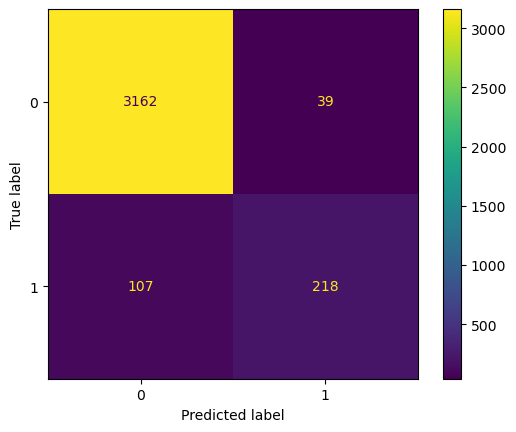

In [38]:
# Build confusion matrix
sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(y_test_array, y_test_pred_svm)
plt.show()

In [39]:
# Generate classification report
print(classification_report(y_test_array, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3201
           1       0.85      0.67      0.75       325

    accuracy                           0.96      3526
   macro avg       0.91      0.83      0.86      3526
weighted avg       0.96      0.96      0.96      3526



# Creating a Decision Trees Model

In [40]:
# Create decision tree instance 
dt_model = DecisionTreeClassifier(random_state=365)

In [41]:
# Set up paramters
parameters_dec_tree = {'ccp_alpha':[0, 
                              0.001, 
                              0.002, 
                              0.003, 
                              0.004, 
                              0.005]}

# Initialize a GridSearchCV object 
grid_search_dec_tree = GridSearchCV(estimator=dt_model, param_grid=parameters_dec_tree, scoring='accuracy')

# Fit the GridSearchCV object on training data
grid_search_dec_tree.fit(x_train_array, y_train_array)


GridSearchCV(estimator=DecisionTreeClassifier(random_state=365),
             param_grid={'ccp_alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005]},
             scoring='accuracy')

In [42]:
# Get the best parameters and best estimator
best_params_dec_tree = grid_search_dec_tree.best_params_
best_dec_tree = grid_search_dec_tree.best_estimator_

# Display best estimator
best_dec_tree

DecisionTreeClassifier(ccp_alpha=0.001, random_state=365)

<Figure size 1500x1000 with 0 Axes>

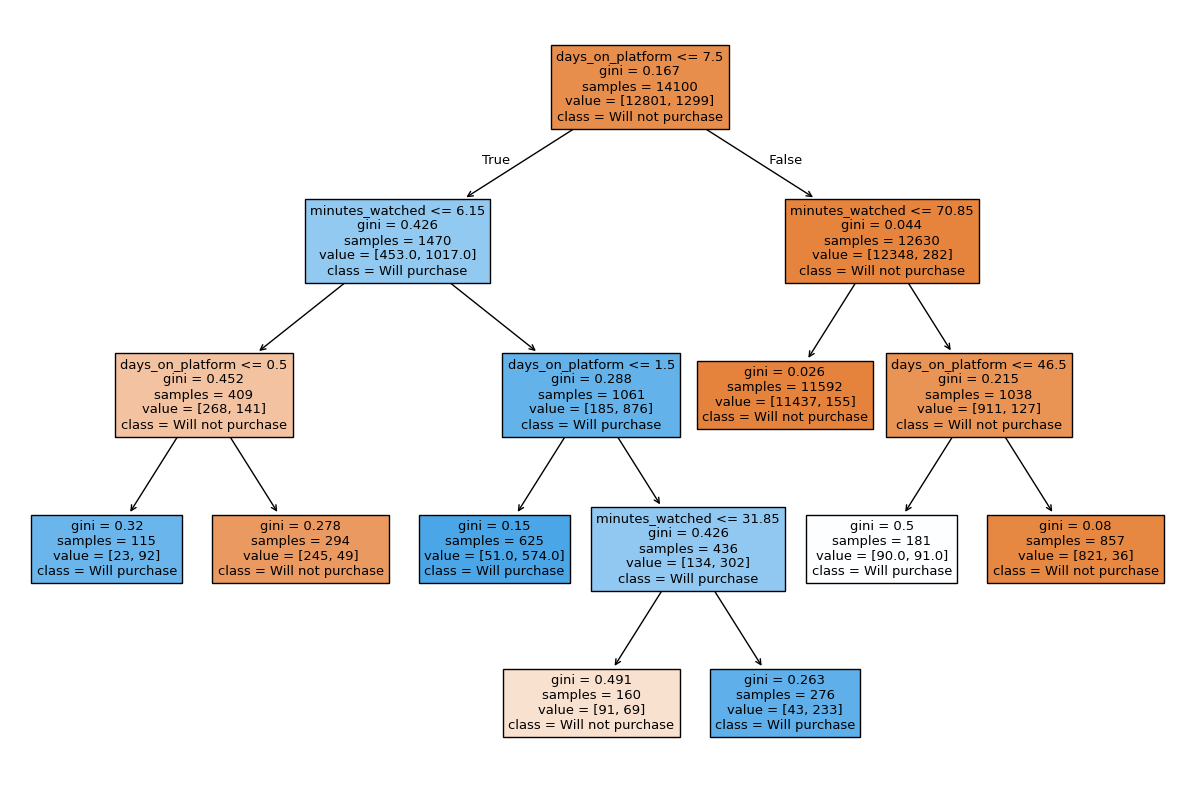

In [44]:
# Use plot_tree function to generate a graphical representation of the decision tree

feature_names = list(x_test.columns)

# Set the figure size for the plot
plt.figure(figsize=(15,10))

# Plot the decision tree. Feature names and class names are added for better interpretability
plot_tree(best_dec_tree, 
          filled=True, 
          feature_names = feature_names, 
          class_names = ['Will not purchase', 
                         'Will purchase'])

# Display the plot
plt.show()


In [45]:
# Make predictions
y_test_pred_dec_tree = best_dec_tree.predict(x_test_array)

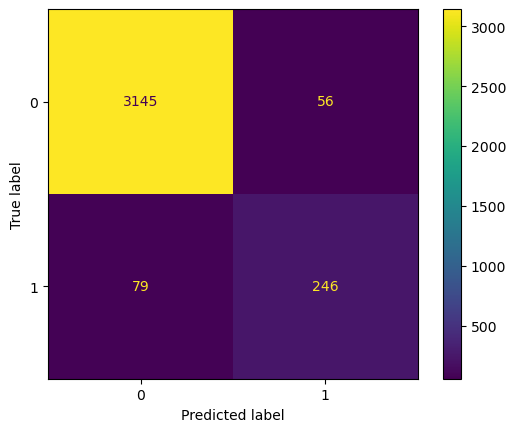

In [46]:
# Build confusion matrix
sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(y_test_array, y_test_pred_dec_tree)
plt.show()

In [47]:
# Generate classification report
print(classification_report(y_test_array, y_test_pred_dec_tree))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3201
           1       0.81      0.76      0.78       325

    accuracy                           0.96      3526
   macro avg       0.90      0.87      0.88      3526
weighted avg       0.96      0.96      0.96      3526



# Creating a Random Forests Model

In [48]:
# Create a Random Forest Classifier
rf = RandomForestClassifier(ccp_alpha = 0.0, random_state = 365)

# Fit the model to your training data
rf.fit(x_train_array, y_train_array)

# Make predictions on your test data
y_pred_rf = rf.predict(x_test_array)

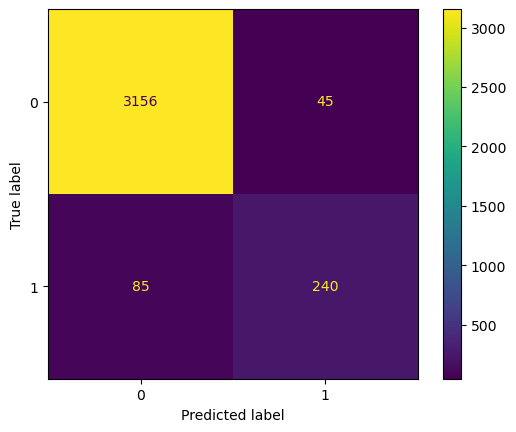

In [49]:
# Build confusion matrix
sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(y_test_array, y_pred_rf)
plt.show()

In [50]:
# Generate classification report
print(classification_report(y_test_array, y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3201
           1       0.84      0.74      0.79       325

    accuracy                           0.96      3526
   macro avg       0.91      0.86      0.88      3526
weighted avg       0.96      0.96      0.96      3526

